### 해리스 코너
해리스는 모라벡의 마스크를 중심에서 멀어질수록 서서히 값이 작아지는 가우시안 마스크 G(x,y)로 대치하였다.  
이렇게 해서 Sum of Squared Difference(SSD)는 다음의 가중치 제곱차의 합(Weighted Sum of Squared Difference(WSSD))로 확장된다.
$$
S(v,u) = \sum_{y} \sum_{x} G(y,x)(f(y+v,x+u)-f(y,x))^2
$$
위의 식은 특징이 될 가능성을 좀더 정밀하게 측정해 주는데, 실제 구현할 때 몇 가지를 고려해야 한다. 이중 가장 중요한 문제는 (v,u)를 어떻게 변화시켜 주위를 조사할 것인지에 관한 것이다.
모라벡의 경우 한 화소만 이동시켜 동서남북(S(0,1),S(0,-1),S(1,0),S(-1,0))을 조사 했다. 하지만 이러한 경우 모든 방향을 동등하게 취급하는 등방성(isotropic property)를 만족하지 못한다.

해리스는 등방성을 만족하기 위해 미분을 도입했다. 테일러 확장(Taylor expansion)에 따르면 아래의 식이 성립한다.
dx와 dy는 각각 [-1,0,1], [-1,0,1]^T 마스크를 영상에 적용한 영상이다.
$$
f(y+v,x+u) \cong f(y,x) + vd_{y}(y,x) + u d_{x}(y,x)
$$
이 식을 S(v,u) 식에 대입하면 아래의 식을 얻는다.
$$
S(v,u) \cong \sum_{y} \sum_{x} G(y,x)(vd_{y}(y,x)+ud_{x}(y,x))^2
$$

해리스는 이 식에서 더 나아가 (v,u)를 바꾸어 가며 인근을 조사하는 것이 아닌, 현재 위치의 영상 '구조'를 나타내는 무엇인가를 도출하기 위해 다음과 같이 식을 옮겼다.

$$
S(v,u)\\ \cong \sum_{y} \sum_{x} G(y,x) (vd_{y}+ud_{x})^2 \\
=\sum_{y} \sum_{x} G(y,x) (v^2d_{y}^2+2vud_{y}d_{x}+u^2d_{x}^2) \\
=\sum_{y} \sum_{x} G(y,x) \begin{pmatrix}v & u \end{pmatrix} \begin{pmatrix}d_{y}^2 &d_{y}d_{x} \\ d_{y}d_{x} & d_{x}^2 \end{pmatrix} \begin{pmatrix} v \\ u\end{pmatrix} \\
=\begin{pmatrix}v & u \end{pmatrix} \sum_{y} \sum_{x} G(y,x) \begin{pmatrix}d_{y}^2 &d_{y}d_{x} \\ d_{y}d_{x} & d_{x}^2 \end{pmatrix} \begin{pmatrix} v \\ u\end{pmatrix} \\
= \begin{pmatrix}v & u \end{pmatrix} \begin{pmatrix}\sum_{y} \sum_{x} G(y,x)d_{y}^2 & \sum_{y} \sum_{x} G(y,x)d_{y}d_{x} \\\sum_{y} \sum_{x} G(y,x)d_{y}d_{x} & \sum_{y} \sum_{x} G(y,x)d_{x}^2 \end{pmatrix} \begin{pmatrix}v \\ u \end{pmatrix} \\
= \begin{pmatrix}v & u \end{pmatrix}\begin{pmatrix} G \circledast d_{y}^2 & G \circledast d_{y}d_{x} \\ G \circledast d_{y}d_{x} & G \circledast d_{x}^2 \end{pmatrix} \begin{pmatrix}v \\ u \end{pmatrix} \\
= \mathbf{uAu^{T}}
$$

여기서 행렬 A는 해리스가 제안한 코너 검출 알고리즘에서 핵심적인 역할을 한다. 
행렬 A는 자가 공관계(auto-correlation) 행렬 또는 2차 모멘트 행렬(second moment matrix)이라 불린다.
행렬 A는 (v,u)와 무관하게 계산할 수 있기 때문에 모라벡 알고리즘 처럼 일일히 (v,u)를 옮겨가며 계산할 필요가 없다. 

다음과 같이 세점의 2차 모멘트 행렬이 있다고 가정해보자.

||a|b|c|
|:---:|:---:|:---:|:---:|
|2차 모멘트 행렬| $$A=\begin{pmatrix}0.522 & -0.199 \\ -0.199 & 0.527 \end{pmatrix}$$ | $$A=\begin{pmatrix}0.522 & -0.199 \\ -0.199 & 0.527 \end{pmatrix}$$ | $$A=\begin{pmatrix}0.522 & -0.199 \\ -0.199 & 0.527 \end{pmatrix}$$|
|고유값|$$\lambda_{1}=0.7235, \lambda_{2}=0.3255$$|$$\lambda_{1}=0.8087, \lambda_{2}=0.0673$$|$$\lambda_{1}=0.0, \lambda_{2}=0.0$$|
|특징 가능성 값|$$C=0.1925$$|$$C=0.0237$$|$$C=0.0$$|

각 행렬의 고유값을 보고 세가지 경우로 나눈다.
- c와 같이 두 개의 고유값 모두 0이거나 0에 가까우면 변화가 거의 없는 픽셀이다.
- b와 같이 고유값 하나는 크고 하나는 작으면 그곳은 한 방향으로만 변화가 있는 에지이다.
- a와 같이 고유값 두 개가 모두 크면 그곳은 여러 방향으로 변화가 있는 지점이다. 이곳이 특징점으로 적합하다.
해리스는 위의 세개의 경우가 일반적으로 적용할 수 있는 규칙임을 입증하고, 이를 바탕으로 고유값 두 개로 정의되는 식을 제안했다.
$$
C=\lambda_{1} \lambda_{2} - k(\lambda_{1}+\lambda_{2})^2
$$

위 식은 두 고유값이 모두 클 때만 큰 값을 가지므로 특징점일 가능성을 측정하는데 용이하다.
여기서 k는 하이퍼파라미터이다. 보통 0.04 정도가 적절한 것으로 알려져 있다.

하지만 이 식은 계산의 효율면에서 부족하다. 고유값을 계산하는데 약간의 시간이 소요되기 때문이다.
고유값의 성질을 이용해 다음을 적용할 수 있다.


$$
\mathbf{A} = \begin{pmatrix}p&r\\r&q \end{pmatrix}$$ 일 때,

$$
\lambda_{1}+\lambda_{2}=p+q=trace(\mathbf{A}) \\
\lambda_{1} \lambda_{2} = pq-r^2 = det(\mathbf{A})
$$.

따라서 C는 다음과 같이 쓸 수 있다.
$$
C=det(\mathbf{A})-k \times trace(\mathbf{A})^2=(pq-r^2)-k(p+q)^2
$$

### 코드 구현

다음과 같이 0,1로 이루어진 이미지가 있다고 가정하자.
위의 표에서 a,b,c는 각각 이 이미지의 [7,7],[5,3],[2,8]에 해당한다.

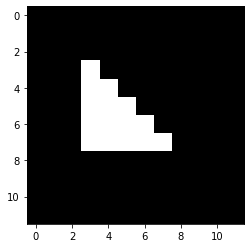

In [1]:
import matplotlib.pyplot as plt
from util import *
import numpy as np
import cv2

img = np.zeros([12,12])
img[3:8,3]=1
img[4:8,4]=1
img[5:8,5]=1
img[6:8,6]=1
img[7,7]=1
plt.imshow(img,cmap='gray')
plt.show()

convolution 연산은 [지난번](https://songminkee.github.io/cv/2020/05/31/edge_detection_basic.html)에 구현한 im2col을 사용한다. 그리고 가우시안 마스크를 만드는 함수를 새로 작성했다.

In [2]:
def get_gaussian_kernel(sigma,size):
    if size % 2 == 0:
        size += 1
    aran = np.arange(-1 * (size // 2), size // 2 + 1)
    XX, YY = np.meshgrid(aran, aran)
    ker = gaussian2d(XX, YY, sigma)
    ker = ker/np.sum(ker) # normalization
    return ker

파이썬의 경우 다음과 같이 하면 [-1,0,1]^T, [-1,0,1] 마스크를 적용한 것과 같다.

In [3]:
mask = get_gaussian_kernel(1, 3)
dy = np.pad(img[1:],((0,1),(0,0))) - np.pad(img[:-1],((1,0),(0,0))) # [-1,0,1]^T 마스크를 적용한 것과 동일
dx = np.pad(img[...,1:],((0,0),(0,1))) - np.pad(img[...,:-1],((0,0),(1,0))) # [-1,0,1] 마스크를 적용한 것과 동일

이제 A행렬의 경우 위의 식과 동일하게 구해진 미분 행렬을 하다마르곱을 한 뒤 가우시안 필터를 적용한다.
이 행렬의 값을 확인하면 위의 표와 일치하는 것을 확인할 수 있다.

In [4]:
A_01 = np.expand_dims(conv(dx * dy, mask), -1)
A_00 = np.expand_dims(conv(dy * dy, mask), -1)
A_11 = np.expand_dims(conv(dx * dx, mask), -1)
A = np.concatenate([np.concatenate([A_00, A_01], -1), np.concatenate([A_01, A_11], -1)], 2)
print("point a\n",A[7,7])
print("point b\n",A[5,3])
print("point c\n",A[2,8])

point a
 [[ 0.52175143 -0.19895501]
 [-0.19895501  0.52697637]]
point b
 [[ 0.07511361 -0.07511361]
 [-0.07511361  0.80104499]]
point c
 [[0. 0.]
 [0. 0.]]


특징 가능성 C 역시 위 표와 동일하다.

In [5]:
k=0.04
deter = np.linalg.det(A)
trace = np.trace(np.transpose(A, (2, 3, 0, 1)))
C = deter - (k* (trace ** 2))
print("point a\n",C[7,7])
print("point b\n",C[5,3])
print("point c\n",C[2,8])

point a
 0.19137437611297517
point b
 0.023821169676266046
point c
 0.0


다음의 사진에서 해리스 코너를 검출해보자.

In [ ]:
img = cv2.imread('./data/red_deer.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(14,14))
plt.imshow(img,cmap='gray')
plt.show()

헤리스 코너는 다음과 같이 함수화 하였다. 아래에 use_det 같은 경우는 본문에서 쓴 바와 같이 두 개의 구현이 실제로 시간적인 차이가 있는지 확인하기 위해 구현한 것이다.  
방금 삼각형이 그려진 이미지와는 다르게  opencv를 이용해 불러온 이미지는 255의 최대값을 가지므로 normalization을 해주어야 한다.

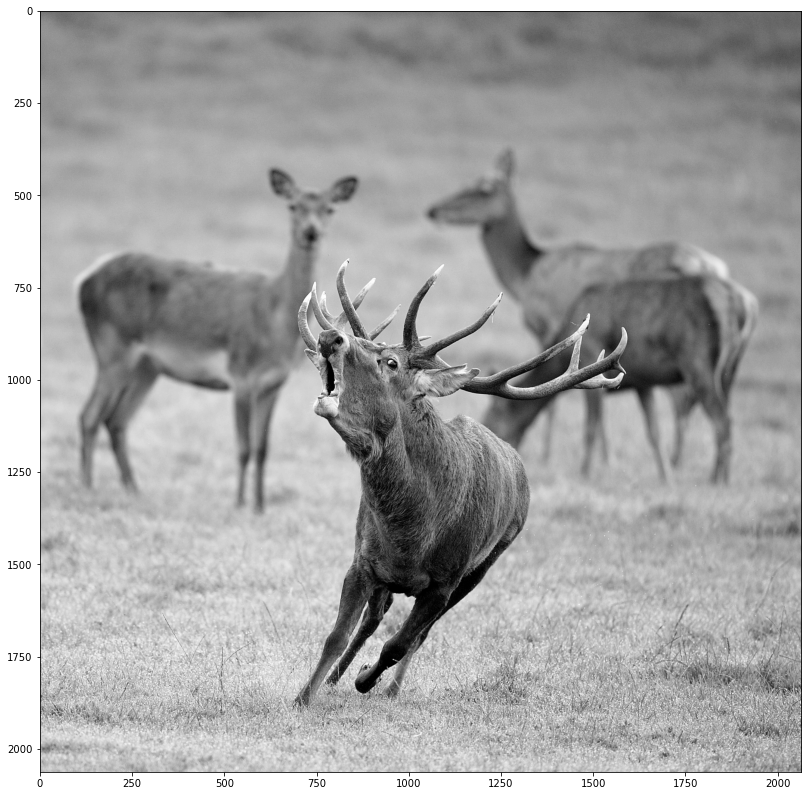

In [6]:
import time

def Harris_corner(img,threshold,use_det=True,k=0.04,max_value=255):
    mask = get_gaussian_kernel(1, 3)
    img = img/max_value
    dy = np.pad(img[1:],((0,1),(0,0))) - np.pad(img[:-1],((1,0),(0,0)))
    dx = np.pad(img[...,1:],((0,0),(0,1))) - np.pad(img[...,:-1],((0,0),(1,0)))

    A_01 = np.expand_dims(conv(dx * dy, mask), -1)
    A_00 = np.expand_dims(conv(dy * dy, mask), -1)
    A_11 = np.expand_dims(conv(dx * dx, mask), -1)
    A = np.concatenate([np.concatenate([A_00, A_01], -1), np.concatenate([A_01, A_11], -1)], 2)

    if use_det:
        deter = np.linalg.det(A)
        trace = np.trace(np.transpose(A, (2, 3, 0, 1)))
        C = deter - (k* (trace ** 2))
    else:
        eigens = np.linalg.eigvals(A)
        C = eigens[..., 0] * eigens[..., 1] - (k * ((eigens[..., 0] + eigens[..., 1]) ** 2))

    return np.where(C>threshold,C,0)

헤리스 코너는 다음과 같이 함수화 하였다. 아래에 use_det 같은 경우는 본문에서 쓴 바와 같이 두 개의 구현이 실제로 시간적인 차이가 있는지 확인하기 위해 구현한 것이다.  
방금 삼각형이 그려진 이미지와는 다르게  opencv를 이용해 불러온 이미지는 255의 최대값을 가지므로 normalization을 해주어야 한다.

In [7]:
import time

def Harris_corner(img,threshold,use_det=True,k=0.04,max_value=255):
    mask = get_gaussian_kernel(1, 3)
    img = img/max_value
    dy = np.pad(img[1:],((0,1),(0,0))) - np.pad(img[:-1],((1,0),(0,0)))
    dx = np.pad(img[...,1:],((0,0),(0,1))) - np.pad(img[...,:-1],((0,0),(1,0)))

    A_01 = np.expand_dims(conv(dx * dy, mask), -1)
    A_00 = np.expand_dims(conv(dy * dy, mask), -1)
    A_11 = np.expand_dims(conv(dx * dx, mask), -1)
    A = np.concatenate([np.concatenate([A_00, A_01], -1), np.concatenate([A_01, A_11], -1)], 2)

    if use_det:
        deter = np.linalg.det(A)
        trace = np.trace(np.transpose(A, (2, 3, 0, 1)))
        C = deter - (k* (trace ** 2))
    else:
        eigens = np.linalg.eigvals(A)
        C = eigens[..., 0] * eigens[..., 1] - (k * ((eigens[..., 0] + eigens[..., 1]) ** 2))

    return np.where(C>threshold,C,0)

또한 검출된 코너를 시각화 하기 위해 다음과 같은 함수를 작성했다. cv2.circle은 이미지에 원을 그려주는 함수인데 x와 y의 순서에 주의를 해야한다.

In [8]:
def draw_harris_circle(img,harris,print_harris_value=False):
    ys, xs = np.where(harris > 0)

    gray = np.expand_dims(img, -1)
    harris_img = np.concatenate([gray, gray, gray], -1)
    for i in range(len(ys)):
        harris_img = cv2.circle(harris_img, (xs[i], ys[i]), 10, (0, 0, 255),-1) # (x,y)로 들어감
        if print_harris_value:
            print("y = {}, x = {}, C = {}".format(ys[i],xs[i],harris[ys[i],xs[i]]))
    return harris_img

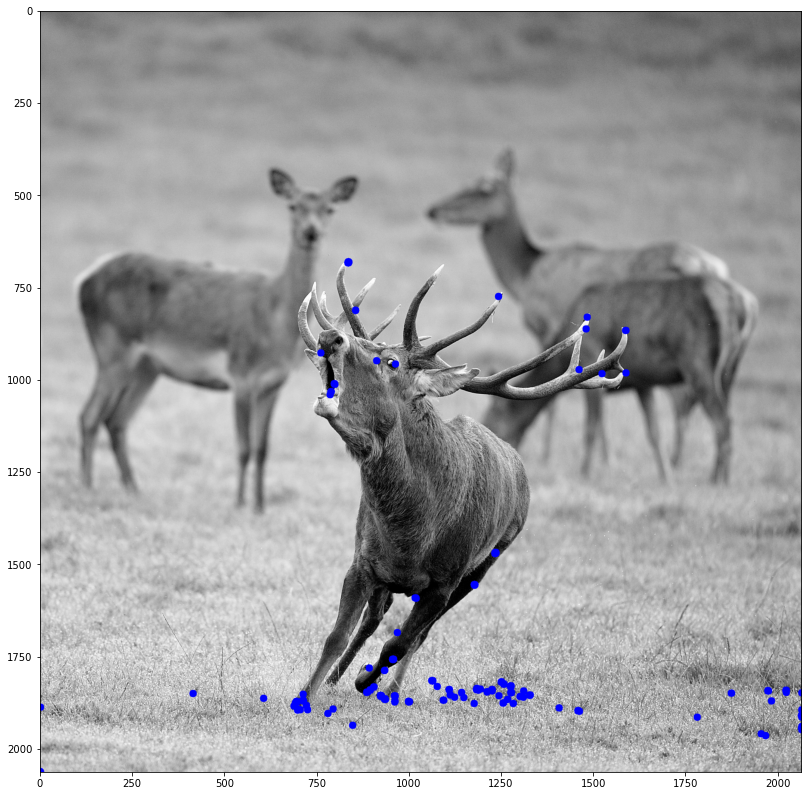

use eigen =  9.849850416183472


In [9]:
start=time.time()
harris = Harris_corner(img,0.02,False)
plt.figure(figsize=(14,14))
plt.imshow(draw_harris_circle(img,harris))
plt.show()
print("use eigen = ", time.time()-start)

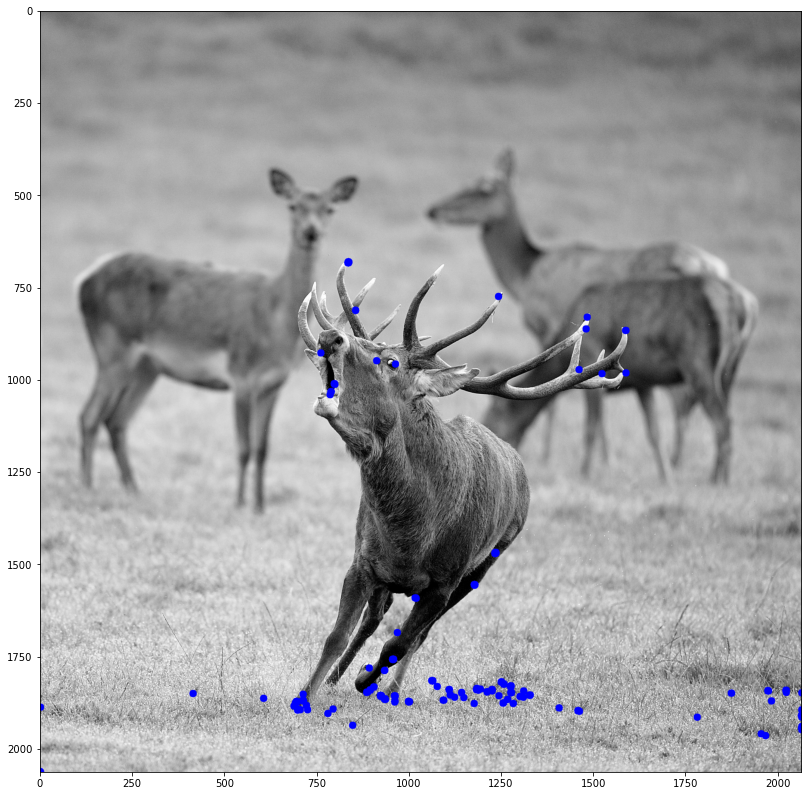

use det =  5.714909315109253


In [10]:
start=time.time()
harris = Harris_corner(img,0.02,True)
plt.figure(figsize=(14,14))
plt.imshow(draw_harris_circle(img,harris))
plt.show()
print("use det = ", time.time()-start)

구현에 따라 분명히 차이가 날 것이고 더 좋은 구현이 있을 것이다. 우선은 고유값을 구하는 데에 시간이 오래 걸린다 정도만 기억 하자. 또한, 두 개의 결과가 동일하다는 것도 볼 수 있다.

해리스는 특징점 검출 알고리즘을 코너 검출기(Corner detector)라고 불렀다.하지만 위의 사진에서는 사슴의 뿔 끄트머리 뿐 아니라 눈동자도 검출 되었다. 이러한 이유로 시간이 지나면서 사람들은 코너라는 용어보다 특징점(feature point) 또는 관심점(interest point)을 주로 사용하게 된다.